In [1]:
pip install kaggle

In [2]:
import os

# Ensure the directory where the dataset will be saved exists
os.makedirs('datasets', exist_ok=True)

# Use the Kaggle API to download the dataset
os.system('kaggle datasets download -d elemento/nyc-yellow-taxi-trip-data -p datasets')

# Unzip the downloaded dataset
os.system('unzip datasets/nyc-yellow-taxi-trip-data.zip -d datasets')


0

In [3]:
os.listdir('datasets')

['yellow_tripdata_2016-01.csv',
 'nyc-yellow-taxi-trip-data.zip',
 'yellow_tripdata_2016-02.csv',
 'yellow_tripdata_2015-01.csv',
 'yellow_tripdata_2016-03.csv']

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')


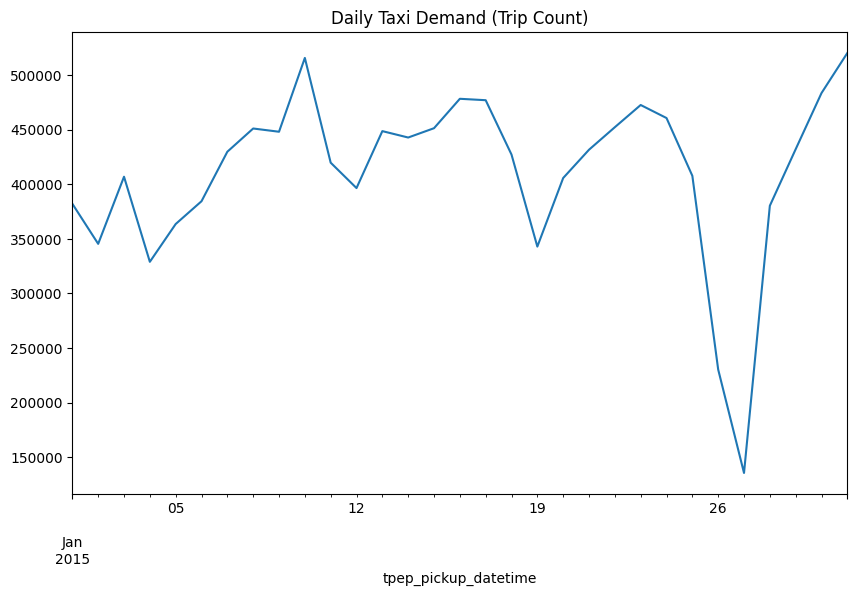

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Load dataset
path = "datasets/yellow_tripdata_2015-01.csv"
df = pd.read_csv(path, parse_dates=['tpep_pickup_datetime'])
print(df.columns)

# Feature Engineering
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
df['pickup_day_of_week'] = df['tpep_pickup_datetime'].dt.dayofweek
df['pickup_date'] = df['tpep_pickup_datetime'].dt.date
df['rush_hour'] = df['pickup_hour'].apply(lambda x: 1 if (7 <= x <= 9 or 17 <= x <= 19) else 0)

# Resample data by day for time series prediction
df.set_index('tpep_pickup_datetime', inplace=True)

daily_data = df.resample('D').agg({
    'trip_distance': 'sum',  # Adjust based on actual column name
    'total_amount': 'sum',   # Adjust based on actual column name
    'extra': 'sum',          # Adjust based on actual column name
    'rush_hour': 'sum'       # This is computed in the previous step
})

# Add trip count as the target variable for demand prediction
daily_data['trip_count'] = df.resample('D').size()

# Plot trip count to visually inspect the time series
daily_data['trip_count'].plot(figsize=(10, 6), title='Daily Taxi Demand (Trip Count)')
plt.show()


ADF Statistic: -1.0265688337162242
p-value: 0.7434510230984599
Critical Value 1%: -3.769732625845229
Critical Value 5%: -3.005425537190083
Critical Value 10%: -2.6425009917355373
Series is not stationary
ADF Statistic: -1.006458332087542
p-value: 0.7509014905291989
Critical Value 1%: -3.769732625845229
Critical Value 5%: -3.005425537190083
Critical Value 10%: -2.6425009917355373
Series is not stationary


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Mean Squared Error: 7045273862.18664
Root Mean Squared Error: 83936.12965932275


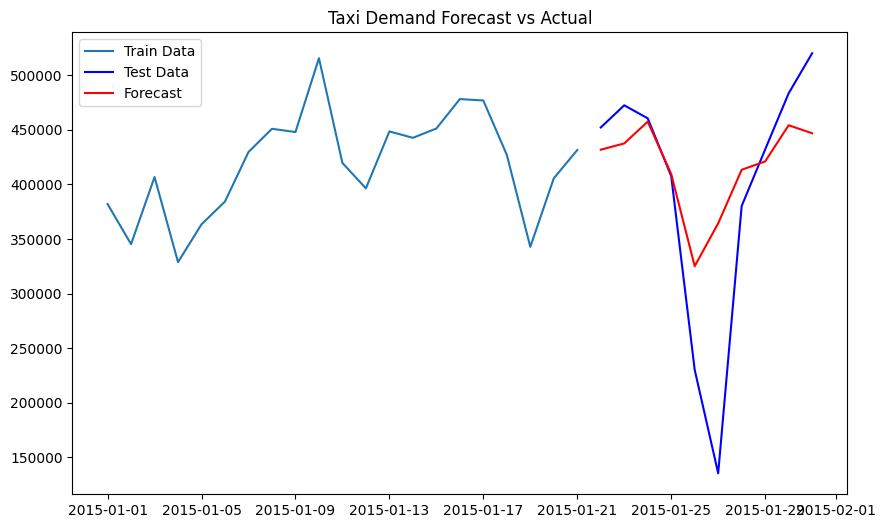

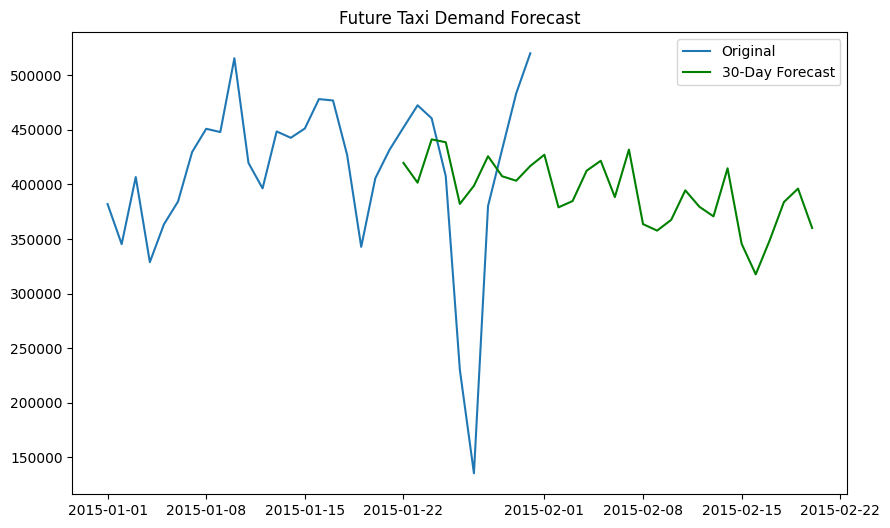

In [5]:

# Check for stationarity using ADF Test
def check_stationarity(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print(f'Critical Value {key}: {value}')
    if result[1] < 0.05:
        print("Series is stationary")
    else:
        print("Series is not stationary")

# Check stationarity of the trip count
check_stationarity(daily_data['trip_count'])

# If not stationary, apply differencing
daily_data['trip_count_diff'] = daily_data['trip_count'].diff().dropna()

# Recheck stationarity after differencing
check_stationarity(daily_data['trip_count_diff'].dropna())

# Split data into train and test (70-30 split)
train_size = int(len(daily_data) * 0.7)
train_data, test_data = daily_data.iloc[:train_size], daily_data.iloc[train_size:]

# Fit SARIMA model on training data
sarima_model_train = SARIMAX(train_data['trip_count'],
                             order=(1, 1, 1),
                             seasonal_order=(1, 1, 1, 7),
                             exog=train_data[['trip_distance', 'extra', 'rush_hour']])
sarima_fit_train = sarima_model_train.fit(disp=False)

# Forecast on test data (use the test exogenous variables for prediction)
forecast_test = sarima_fit_train.get_forecast(steps=len(test_data),
                                              exog=test_data[['trip_distance', 'extra', 'rush_hour']])
forecast_test_values = forecast_test.predicted_mean

# Calculate Mean Squared Error (MSE) or Root Mean Squared Error (RMSE)
mse = mean_squared_error(test_data['trip_count'], forecast_test_values)
rmse = np.sqrt(mse)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')

# Plot the forecasted vs actual values
plt.figure(figsize=(10, 6))
plt.plot(train_data['trip_count'], label='Train Data')
plt.plot(test_data['trip_count'], label='Test Data', color='blue')
plt.plot(forecast_test_values, label='Forecast', color='red')
plt.title('Taxi Demand Forecast vs Actual')
plt.legend()
plt.show()
# Forecast future taxi demand
forecast_future = sarima_fit_train.get_forecast(steps=30,
                                                exog=daily_data[['trip_distance', 'extra', 'rush_hour']].tail(30))
forecast_future_values = forecast_future.predicted_mean
# Plot future forecast
plt.figure(figsize=(10, 6))
plt.plot(daily_data['trip_count'], label='Original')
plt.plot(forecast_future_values, label='30-Day Forecast', color='green')
plt.title('Future Taxi Demand Forecast')
plt.legend()
plt.show()
